# Figure 4

In [1]:
import numpy as np
import os, glob
import datetime
from netCDF4 import Dataset
from collections import namedtuple
from scipy import stats

from matplotlib.pyplot import *
import matplotlib.pyplot as plt

In [2]:
def colorplotLeft(ax):
    
    almost_black = '#262626' # tweek from Thorsten
    
    for spx in ['top','right']:
            ax.spines[spx].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # set axis positions
#     ax.yaxis.set_label_position(pspines[0]) 
#     ax.xaxis.set_label_position(pspines[1]) 
    
    for spx in ['bottom','left']:
        ax.spines[spx].set_linewidth(0.5)
        ax.spines[spx].set_color(almost_black)
    
    for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        ticks.set_color(almost_black)

In [3]:
def anomaly(data):
	"""calculate anomaly of a 1D array (assumes no missing time slots)"""
	d1=np.ma.copy(data)
	ind=np.ma.array(range(len(data))) % 12
	for num in range(12):
		d1[num == ind]=data[num == ind]-np.ma.average(data[num == ind])
	return d1

In [4]:
## ceres data; from fig. 3 file
## based on regression up to 7/17
ceresR=-0.17
ceresRta=-0.46

## read in models & calculate correlation

In [5]:
modelRun = namedtuple('modelRun', ('t', 'ts','t_trop','ts_trop','flux'))
modelType = namedtuple('modelType', ('piControl','abrupt4xCO2'))

def readFile(modx,runx):
	"""read global and tropical avg. nc file"""
	fni=Dataset('cmip5/{0}.{1}.nc'.format(mn,runx))
	ovar=[]
	for ii in ['flux','ta','tas','t_trop','tas_trop']:
		ovar.append(anomaly(fni[ii][:].squeeze()))
	modout=modelRun(flux=ovar[0],t=ovar[1],ts=ovar[2],t_trop=ovar[3],ts_trop=ovar[4])
	return modout

# get names of models
fn=glob.glob('cmip5/*.{}.nc'.format('piControl'))
models=[ii.split('/')[1] for ii in fn]
models=[ii.split('.')[0] for ii in models]
models.sort()

In [6]:
skip=17*12;length=17

feedbacks={};modelOutput={}
for mn in models:
	piC=readFile(mn,'piControl')	
	abrupt=readFile(mn,'abrupt4xCO2')
	feedbacks[mn]=modelType(piControl=piC,abrupt4xCO2=abrupt)
	print('{} '.format(mn),end="")
	sys.stdout.flush()

	## analyze the run
	m1all=[];abrupt=[]
	for latr,varn in zip(['90','30'],['ts','t']):
		
		mod1=feedbacks[mn].piControl # control run
		s=len(mod1.t)

		tvar=varn
		if latr == '30': tvar = tvar+'_trop'
		commandStr='tg=mod1.{}'.format(tvar)
		exec(commandStr)

		# flux is the same for all calcs
		flux=mod1.flux
		
		m1=[]
		for ii in range(0,s-length*12,skip):
			indx=range(ii,ii+length*12)
			fitx=stats.linregress(anomaly(tg[indx]),anomaly(flux[indx]))
			m1.append(fitx[2])

		m1all.append(m1)

	modelOutput[mn]=modelType(piControl=m1all,abrupt4xCO2=[0])

ACCESS1-0 ACCESS1-3 BCC-CSM1-1 BCC-CSM1-1-M CCSM4 CNRM-CM5 CNRM-CM5-2 CSIRO-Mk3-6-0 

/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


CanESM2 FGOALS-g2 FGOALS-s2 GFDL-CM3 GFDL-ESM2G GFDL-ESM2M GISS-E2-H GISS-E2-R HadGEM2-ES INMCM4 IPSL-CM5A-LR IPSL-CM5A-MR IPSL-CM5B-LR MIROC-ESM MIROC5 MPI-ESM-LR MPI-ESM-MR MPI-ESM-P MRI-CGCM3 NorESM1-M 

## figure 4 plot

In [10]:
if False:
    figure(figsize=(9,7))
    plt.subplots_adjust(bottom=0.2)
    values1=np.array([np.average(modelOutput[ii].piControl[0]) for ii in models])
    values2=np.array([np.max(modelOutput[ii].piControl[0]) for ii in models])
    values3=np.array([np.min(modelOutput[ii].piControl[0]) for ii in models])
    errorbar(np.arange(len(values1)),values1,yerr=[values1-values3,values2-values1],fmt='o',color='k')
    ylim(np.average(values1)-0.4,np.average(values1)+0.4)#;grid()
    ylabel('correlation coefficient',fontsize=16)
    axhline(ceresR,color='r',ls='dashed') # from Fig. 1 file
    axhline(np.average(values1),color='b',ls='dashed')
    gca().set_xticks(range(len(models)));
    gca().set_xticklabels(models,rotation='90');
    xlim(-0.5,len(models)-0.5)
    colorplotLeft(gca())
    # savefig('fig4.eps')

In [14]:
if False:
    figure(figsize=(7,9))
    plt.subplots_adjust(left=0.2)
    values1=np.array([np.average(modelOutput[ii].piControl[0]) for ii in models])
    values2=np.array([np.max(modelOutput[ii].piControl[0]) for ii in models])
    values3=np.array([np.min(modelOutput[ii].piControl[0]) for ii in models])
    errorbar(values1,np.arange(len(values1)),xerr=[values1-values3,values2-values1],fmt='o',color='k')
    xlim(np.average(values1)-0.4,np.average(values1)+0.4)#;grid()
    xlabel('correlation coefficient',fontsize=16)
    axvline(ceresR,color='r',ls='dashed') # from Fig. 1 file
    axvline(np.average(values1),color='b',ls='dashed')
    gca().set_yticks(range(len(models)));
    gca().set_yticklabels(models);
    ylim(-0.5,len(models)-0.5)
    colorplotLeft(gca())
    # savefig('fig4.eps')

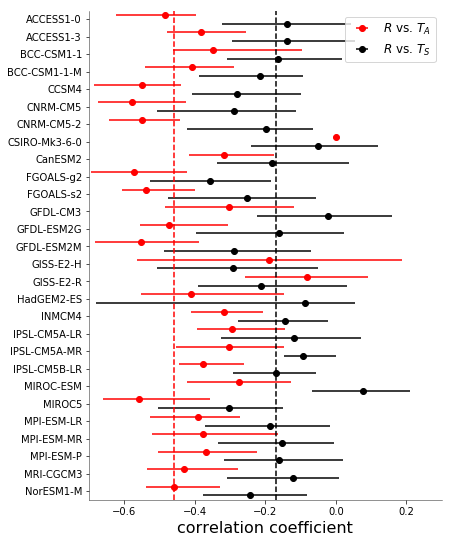

In [12]:
figure(figsize=(7,9))
plt.subplots_adjust(left=0.2)

if models[0][0] == 'A':
    models=models[::-1]

values1=np.array([np.average(modelOutput[ii].piControl[1]) for ii in models])
values2=np.array([np.max(modelOutput[ii].piControl[1]) for ii in models])
values3=np.array([np.min(modelOutput[ii].piControl[1]) for ii in models])
errorbar(values1,np.arange(len(values1))+0.25,xerr=[values1-values3,values2-values1],fmt='o',color='r',label='$R$ vs. $T_A$')

values1=np.array([np.average(modelOutput[ii].piControl[0]) for ii in models])
values2=np.array([np.max(modelOutput[ii].piControl[0]) for ii in models])
values3=np.array([np.min(modelOutput[ii].piControl[0]) for ii in models])
errorbar(values1,np.arange(len(values1))-0.25,xerr=[values1-values3,values2-values1],fmt='o',color='k',label='$R$ vs. $T_S$')

xlim(-0.7,0.3)
xlabel('correlation coefficient',fontsize=16)
axvline(ceresR,color='k',ls='dashed') # from Fig. 1 file
axvline(ceresRta,color='r',ls='dashed') # from Fig. 1 file

# axvline(np.average(values1),color='b',ls='dashed')
gca().set_yticks(range(len(models)));
gca().set_yticklabels(models);
ylim(-0.5,len(models)-0.5)
colorplotLeft(gca())
legend(fontsize=12)
# savefig('fig4.eps')
savefig('fig4')